# <center> Learned primal dual data architecture </center>

In this notebook we present how to generate the data and the architecture for our problem of microlocal analysis of the learned primal dual

## Utilitary libraries

In [1]:
%matplotlib inline
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import os
import adler
adler.util.gpu.setup_one_gpu(0)

Picking GPU 0


In [3]:
from adler.odl.phantom import random_phantom
from adler.tensorflow import prelu, cosine_decay

In [4]:
import tensorflow as tf
import numpy as np
import odl
import odl.contrib.tensorflow

In [5]:
np.random.seed(0)
#name = os.path.splitext(os.path.basename(__file__))[0]
name = os.path.splitext(os.getcwd())[0]+'/checkpoints'

In [6]:
# Creating checkpoints directory
try:
    os.mkdir(name)
except OSError:
    print ("Creation of the directory %s failed" % name)
else:
    print ("Successfully created the directory %s " % name)

Creation of the directory /store/kepler/datastore/andrade/GitHub_repos/Joint_CTWF_Recon/Microcanonical_NN/Tensorflow_microlocal/checkpoints failed


In [7]:
sess = tf.InteractiveSession()

## Loading data

In [8]:
import sys
sys.path.append("../../WF_inpaint/")

In [30]:
# Import the needed modules
from data.data_factory import random_realphantom
from ellipse.ellipseWF_factory import plot_WF, WFupdate, WFupdate_sino

import matplotlib.pyplot as plt
import numpy.random as rnd
import numpy as np
import odl
import matplotlib.pyplot as plt

### Real phantom with WFset generation full and low dose

In [31]:
size = 256
nClasses = 180
lowd = 40

In [32]:
nRegions = np.random.randint(5,10)
npoints_max = np.random.randint(8,15)
realphantom, WFpoints, WFclasses,  WFimage = random_realphantom(size, nRegions, npoints_max, nClasses)

# Compute low dose WF image
angles_lowd = np.array([i for i in range(0,180,int(180/lowd))])
# Extracting the wavefront set orientations in the low dose
angles_gt = (np.array(WFclasses).astype(int)[:,0]-1)
angles_gt_lowd = np.array([angle in angles_lowd for angle in angles_gt])
# Generating the new WFpoints and classes
WFpoints_lowd = WFpoints[angles_gt_lowd]
WFclasses_lowd = list(np.array(WFclasses)[angles_gt_lowd])
# Generating the low dose WFimage
WFimage_lowd = np.zeros([size,size])
WFimage_lowd = WFupdate(WFpoints_lowd, WFclasses_lowd, WFimage_lowd)

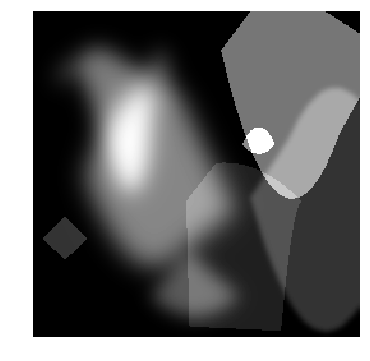

In [33]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(realphantom, cmap="gray")

In [1]:
#### plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF(WFimage)

NameError: name 'plt' is not defined

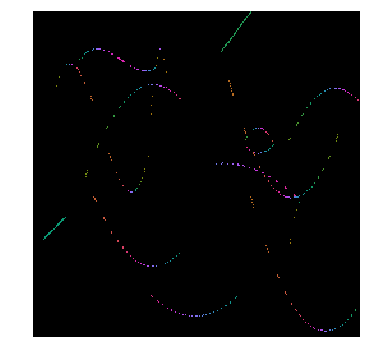

In [35]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF(WFimage_lowd)

### Sinogram of real phantom with WFset generation with full and lowd

In [36]:
from ray_transform.canon_relation import (point_img2sino, class_img2sino, CanRel_img2sino, 
                                         point_sino2img, CanRel_sino2img)

In [37]:
# Create ODL data structures
space = odl.uniform_discr([-int(size/2), -int(size/2)], [int(size/2), int(size/2)], [size, size],
                          dtype='float32')

In [38]:
# Full dose radon transform
geometry = odl.tomo.parallel_beam_geometry(space, num_angles=180)
operator = odl.tomo.RayTransform(space, geometry)
opnorm = odl.power_method_opnorm(operator)
operator = (1 / opnorm) * operator

In [39]:
# Low dose radon transform
geometry_lowd = odl.tomo.parallel_beam_geometry(space, num_angles=lowd)
operator_lowd = odl.tomo.RayTransform(space, geometry_lowd)
opnorm_lowd = odl.power_method_opnorm(operator_lowd)
operator_lowd = (1 / opnorm_lowd) * operator_lowd

In [40]:
# Full dose sinogram
sinogram = np.array(operator(space.element(realphantom)))
sinogram_shape = sinogram.shape
WFpoints_sino, WFclasses_sino = CanRel_img2sino(WFpoints, WFclasses, size, sinogram_shape, num_angles = 180)
WFimage_sino = np.zeros(sinogram.shape)
WFimage_sino = WFupdate_sino(WFpoints_sino, WFclasses_sino, WFimage_sino)

In [41]:
# Low dose sinogram
sinogram_lowd= np.array(operator_lowd(space.element(realphantom)))
sinogram_shape_lowd = sinogram_lowd.shape
WFpoints_sino_lowd, WFclasses_sino_lowd = CanRel_img2sino(WFpoints_lowd, WFclasses_lowd, size, sinogram_shape_lowd, num_angles = 180)
WFpoints_sino_lowd[:,1] = lowd* WFpoints_sino_lowd[:,1]/180
WFimage_sino_lowd = np.zeros(sinogram_lowd.shape)
WFimage_sino_lowd = WFupdate_sino(WFpoints_sino_lowd, WFclasses_sino_lowd, WFimage_sino_lowd)

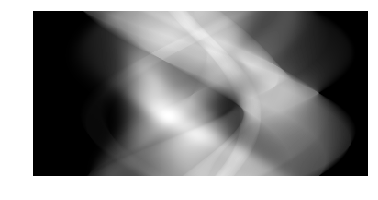

In [42]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(sinogram , cmap="gray")

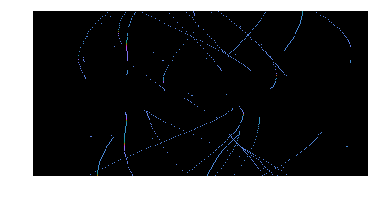

In [43]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF(WFimage_sino)

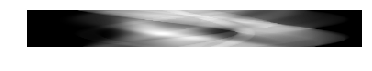

In [44]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(sinogram_lowd , cmap="gray")

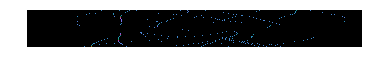

In [45]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF(WFimage_sino_lowd)

### Canonical relation full and low dose sinogram

In [46]:
# Full dose
WFpoints_canon, WFclasses_canon = CanRel_sino2img(WFpoints_sino, WFclasses_sino, size, sinogram_shape, num_angles=180)
WFimage_canon = np.zeros([size,size])
WFimage_canon = WFupdate(WFpoints_canon, WFclasses_canon, WFimage_canon)

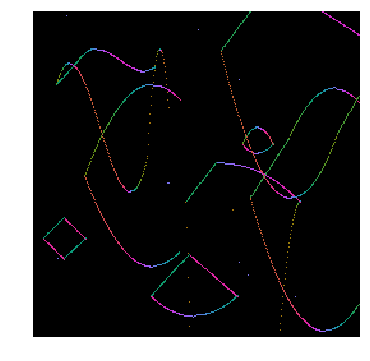

In [47]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF(WFimage_canon)

In [48]:
# Low dose
## Upscaling WFpoints_sino_lowd
WFpoints_sino_lowd_up = WFpoints_sino_lowd.copy()
WFpoints_sino_lowd_up[:,1] = WFpoints_sino_lowd_up[:,1]*180/lowd
WFclasses_sino_lowd_up = WFclasses_sino_lowd

In [49]:
WFpoints_canon_lowd, WFclasses_canon_lowd = CanRel_sino2img(WFpoints_sino_lowd_up, WFclasses_sino_lowd_up, size, (180,sinogram_shape[1]) , num_angles = lowd)
WFimage_canon_lowd = np.zeros([size,size])
WFimage_canon_lowd = WFupdate(WFpoints_canon_lowd, WFclasses_canon_lowd, WFimage_canon_lowd)

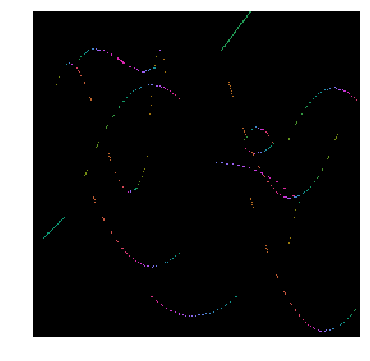

In [50]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF(WFimage_canon_lowd)

## Data generator for CT recon

In [51]:
size = 256
nClasses = 180
lowd = 40
nRegions = np.random.randint(5,10)
npoints_max = np.random.randint(8,15)

In [52]:
batch_size = 5
n_iter = 10
n_primal = 5
n_dual = 5

In [53]:
def generate_data_CT(validation=False):
    """Generate a set of random data."""
    if validation:
        n_generate = 1
    else: 
        n_generate = batch_size

    y_arr = np.empty((n_generate, operator_lowd.range.shape[0], operator_lowd.range.shape[1], 1), dtype='float32')
    x_true_arr = np.empty((n_generate, space.shape[0], space.shape[1], 1), dtype='float32')

    for i in range(n_generate):
        if validation:
            phantom = odl.phantom.shepp_logan(space, True)
        else:
            phantom, _, _,  _ = random_realphantom(size, nRegions, npoints_max, nClasses)
        data = operator_lowd(phantom)
        noisy_data = data + odl.phantom.white_noise(operator_lowd.range) * np.mean(np.abs(data)) * 0.05

        x_true_arr[i, ..., 0] = phantom
        y_arr[i, ..., 0] = noisy_data

    return y_arr, x_true_arr

In [54]:
y_arr, x_true_arr = generate_data_CT()

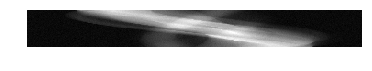

In [55]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(y_arr[0,:,:,0], cmap="gray")

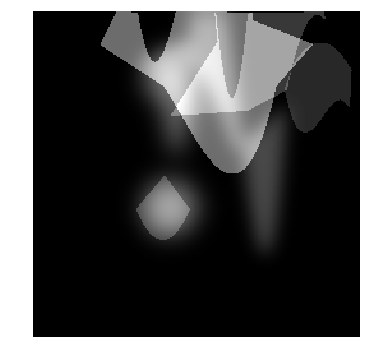

In [56]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(x_true_arr[0,:,:,0], cmap="gray")

## Learned primal dual model

In [57]:
# Create tensorflow layer from odl operator
odl_op_layer = odl.contrib.tensorflow.as_tensorflow_layer(operator_lowd,
                                                          'RayTransform')
odl_op_layer_adjoint = odl.contrib.tensorflow.as_tensorflow_layer(operator_lowd.adjoint,
                                                                  'RayTransformAdjoint')

In [58]:
with tf.name_scope('placeholders'):
    x_true = tf.placeholder(tf.float32, shape=[None, size, size, 1], name="x_true")
    y_rt = tf.placeholder(tf.float32, shape=[None, operator_lowd.range.shape[0], operator_lowd.range.shape[1], 1], name="y_rt")
    is_training = tf.placeholder(tf.bool, shape=(), name='is_training')

In [59]:
def apply_conv(x, filters=32):
    return tf.layers.conv2d(x, filters=filters, kernel_size=3, padding='SAME',
                            kernel_initializer=tf.contrib.layers.xavier_initializer(), use_bias=False)

In [60]:
relu = tf.nn.relu

In [61]:
with tf.name_scope('tomography'):
    with tf.name_scope('initial_values'):
        primal = tf.concat([tf.zeros_like(x_true)] * n_primal, axis=-1)
        dual = tf.concat([tf.zeros_like(y_rt)] * n_dual, axis=-1)

    for i in range(n_iter):
        with tf.variable_scope('dual_iterate_{}'.format(i)):
            evalop = odl_op_layer(primal[..., 1:2])
            update = tf.concat([dual, evalop, y_rt], axis=-1)

            #update = prelu(apply_conv(update), name='prelu_1')
            #update = prelu(apply_conv(update), name='prelu_2')
            update = relu(apply_conv(update), name='relu_1')
            update = relu(apply_conv(update), name='relu_2')            
            update = apply_conv(update, filters=n_dual)
            dual = dual + update

        with tf.variable_scope('primal_iterate_{}'.format(i)):
            evalop = odl_op_layer_adjoint(dual[..., 0:1])
            update = tf.concat([primal, evalop], axis=-1)

            update = relu(apply_conv(update), name='relu_1')
            update = relu(apply_conv(update), name='relu_2')
            update = apply_conv(update, filters=n_primal)
            primal = primal + update

    x_result = primal[..., 0:1]

In [62]:
with tf.name_scope('loss'):
    residual = x_result - x_true
    squared_error = residual ** 2
    loss = tf.reduce_mean(squared_error)

In [63]:
with tf.name_scope('optimizer'):
    # Learning rate
    global_step = tf.Variable(0, trainable=False)
    maximum_steps = 100001
    starter_learning_rate = 1e-3
    learning_rate = cosine_decay(starter_learning_rate,
                                 global_step,
                                 maximum_steps,
                                 name='learning_rate')

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        opt_func = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                          beta2=0.99)

        tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tvars), 1)
        optimizer = opt_func.apply_gradients(zip(grads, tvars),
                                             global_step=global_step)

In [64]:
ckp_name = name+'_lpd_nobias/checkpoints'

In [ ]:
# Summaries
# tensorboard --logdir=...

with tf.name_scope('summaries'):
    tf.summary.scalar('loss', loss)
    tf.summary.scalar('psnr', -10 * tf.log(loss) / tf.log(10.0))

    tf.summary.image('x_result', x_result)
    tf.summary.image('x_true', x_true)
    tf.summary.image('squared_error', squared_error)
    tf.summary.image('residual', residual)

    merged_summary = tf.summary.merge_all()
    test_summary_writer = tf.summary.FileWriter(adler.tensorflow.util.default_tensorboard_dir(ckp_name) + '/test',
                                                sess.graph)
    train_summary_writer = tf.summary.FileWriter(adler.tensorflow.util.default_tensorboard_dir(ckp_name) + '/train')

In [ ]:
# Initialize all TF variables
sess.run(tf.global_variables_initializer())

In [ ]:
# Generate validation data
y_arr_validate, x_true_arr_validate = generate_data_CT(validation=True)

In [ ]:
# Add op to save and restore
saver = tf.train.Saver()

In [ ]:
# Train the network
for i in range(0, maximum_steps):
    if i%10 == 0:
        y_arr, x_true_arr = generate_data_CT()

    _, merged_summary_result_train, global_step_result = sess.run([optimizer, merged_summary, global_step],
                              feed_dict={x_true: x_true_arr,
                                         y_rt: y_arr,
                                         is_training: True})
    
    if i>0 and i%10 == 0:
        loss_result, merged_summary_result, global_step_result = sess.run([loss, merged_summary, global_step],
                              feed_dict={x_true: x_true_arr_validate,
                                         y_rt: y_arr_validate,
                                         is_training: False})

        train_summary_writer.add_summary(merged_summary_result_train, global_step_result)
        test_summary_writer.add_summary(merged_summary_result, global_step_result)

        print('iter={}, loss={}'.format(global_step_result, loss_result))

    if i>0 and i%1000 == 0:
        saver.save(sess,
                   adler.tensorflow.util.default_checkpoint_path(ckp_name))

iter=11, loss=0.03880983591079712
iter=21, loss=0.032682470977306366
iter=31, loss=0.02472984977066517
iter=41, loss=0.024265125393867493
iter=51, loss=0.021204113960266113
iter=61, loss=0.021739430725574493
iter=71, loss=0.02425554022192955
iter=81, loss=0.02190171182155609
iter=91, loss=0.01942433789372444
iter=101, loss=0.01774424873292446
iter=111, loss=0.015685444697737694
iter=121, loss=0.01444657426327467
iter=131, loss=0.020650601014494896
iter=141, loss=0.022354185581207275
iter=151, loss=0.022090813145041466
iter=161, loss=0.021189039573073387
iter=171, loss=0.017325516790151596
iter=181, loss=0.015275553800165653
iter=191, loss=0.013817238621413708
iter=201, loss=0.01275877095758915
iter=211, loss=0.012106236070394516
iter=221, loss=0.015374008566141129
iter=231, loss=0.01760164275765419
iter=241, loss=0.016707176342606544
iter=251, loss=0.01593160256743431
iter=261, loss=0.015446792356669903
iter=271, loss=0.016181491315364838
iter=281, loss=0.017050616443157196
iter=291, l

In [ ]:
iterate = 0
conv_layer = 0
dual = False

In [ ]:
if dual== True:
    ld = 'dual'
    shape = operator_lowd.range.shape
else:
    ld = 'primal'
    shape = operator_lowd.domain.shape

In [ ]:
if conv_layer == 0:
    conv_name = '/conv2d/'
else:
    conv_name = '/conv2d_'+str(conv_layer)+'/'

In [ ]:
name_kernel = (ld+'_iterate_'+str(iterate)+conv_name+'kernel:0')
name_bias = (ld+'_iterate_'+str(iterate)+conv_name+'bias:0')

In [ ]:
kernels = gr.get_tensor_by_name(name_kernel)
bias = gr.get_tensor_by_name(name_bias)

In [ ]:
x_true = realphantom_tf 
y_rt = sinogram_lowd_tf;

In [ ]:
primal_values_result, dual_values_result = sess.run([primal_values, dual_values],
                      feed_dict={x_true: x_true,
                                 y_rt: y_rt,
                                 is_training: False})